In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json

In [2]:
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

In [3]:
text_df = pd.read_csv("training_subset.csv")
text_df.head()

,submission_title,comment,comment_id,url,subreddit_id,label1,label2
0,Shashi Tharoor Set To Run For Congress Preside...,Extremely valid points but I believe he has th...,ip5g6vu,/r/india/comments/xif8wm/shashi_tharoor_set_to...,2qh1q,-1,-1
1,Yogi government puts Kolkata's image as part o...,Even if the ad was designed by the newspaper -...,hcontm8,/r/india/comments/pmn9o3/yogi_government_puts_...,2qh1q,-1,-1
2,"An attempt to address the list of ""simplified""...",Diverse population including Muslims. Welcomin...,fbhlv40,/r/india/comments/ebdeup/an_attempt_to_address...,2qh1q,-1,-2
3,You guys noticing what's happening in Sri Lanka?,>The blockade was done by your own people.\n\n...,i2yrud3,/r/india/comments/tt1ryh/you_guys_noticing_wha...,2qh1q,0,0
4,Just got abused on the train by a hyper-nation...,Ohoo bahut bura laga ye sunke ki aap Undergarm...,hooi92k,/r/india/comments/rh2kcs/just_got_abused_on_th...,2qh1q,-2,-2


In [4]:
text_df.describe()

,label1,label2
count,2045.000000,2045.000000
mean,-0.061125,-0.094866
std,0.884571,0.968081
min,-2.000000,-2.000000
25%,-1.000000,-1.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,2.000000,2.000000


In [5]:
text_df['avg_score'] = text_df.apply(lambda x: np.mean(x[5:]), axis=1)
text_df.head()

,submission_title,comment,comment_id,url,subreddit_id,label1,label2,avg_score
0,Shashi Tharoor Set To Run For Congress Preside...,Extremely valid points but I believe he has th...,ip5g6vu,/r/india/comments/xif8wm/shashi_tharoor_set_to...,2qh1q,-1,-1,-1.0
1,Yogi government puts Kolkata's image as part o...,Even if the ad was designed by the newspaper -...,hcontm8,/r/india/comments/pmn9o3/yogi_government_puts_...,2qh1q,-1,-1,-1.0
2,"An attempt to address the list of ""simplified""...",Diverse population including Muslims. Welcomin...,fbhlv40,/r/india/comments/ebdeup/an_attempt_to_address...,2qh1q,-1,-2,-1.5
3,You guys noticing what's happening in Sri Lanka?,>The blockade was done by your own people.\n\n...,i2yrud3,/r/india/comments/tt1ryh/you_guys_noticing_wha...,2qh1q,0,0,0.0
4,Just got abused on the train by a hyper-nation...,Ohoo bahut bura laga ye sunke ki aap Undergarm...,hooi92k,/r/india/comments/rh2kcs/just_got_abused_on_th...,2qh1q,-2,-2,-2.0


In [6]:
text_df.describe()

,label1,label2,avg_score
count,2045.000000,2045.000000,2045.000000
mean,-0.061125,-0.094866,-0.077995
std,0.884571,0.968081,0.866536
min,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-0.500000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.500000
max,2.000000,2.000000,2.000000


## Text Cleaning
 - Remove all quotes of previous comments (starts with ">" and ends with newline)
 - Remove special characters other than ,.'"?!
 - Remove links

In [7]:
def clean_quotations(text):
    temp = re.sub(r'>.*?\n', '', text)
    return temp

In [7]:
# clean_punc = re.compile('[^a-zA-Z0-9\s]')
# print(clean_punc.sub('', reviews[0]["text"][0].lower()))

In [8]:
text_df['comment'][3]

">The blockade was done by your own people.\n\nWhat a joke. \n\n>The simple truth is that your communist party aligned with China and created propaganda against India.\n\nThey didn't create any propaganda. India helped their civil war. They are puppet of India. Majority of them have no courage to talk anything about India. \n\nPeople in India die due to Koshi that's why India wants to construct another larger dam so that only Nepali would die.\n\nAnd another simple explanation, when India initiated a road in Lipulekh Kalapani area (which according to Sugauli treaty) is part of Nepal. India never talked about it with Nepal. Because India dissolved the treaty without Nepal's agreement. \n\nWhen every argument ends, we have common culture is your ultimate sword."

In [9]:
clean_quotations(text_df['comment'][3])

"\nWhat a joke. \n\n\nThey didn't create any propaganda. India helped their civil war. They are puppet of India. Majority of them have no courage to talk anything about India. \n\nPeople in India die due to Koshi that's why India wants to construct another larger dam so that only Nepali would die.\n\nAnd another simple explanation, when India initiated a road in Lipulekh Kalapani area (which according to Sugauli treaty) is part of Nepal. India never talked about it with Nepal. Because India dissolved the treaty without Nepal's agreement. \n\nWhen every argument ends, we have common culture is your ultimate sword."

In [8]:
def clean_url(text):
    temp = re.sub(r'(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+\.~#?&\/=]*)', '', text)
    return temp

In [9]:
def clean_text(text):
    temp = clean_quotations(text)
    temp = clean_url(temp)
    temp = re.sub(r'[^a-zA-Z0-9\s\.,?!\'\"]', ' ', temp)
    temp = re.sub(r'\s+', ' ', temp)  # replace multiple spaces with single space
    return temp.strip()

In [10]:
clean_text(text_df['comment'][3])

"What a joke. They didn't create any propaganda. India helped their civil war. They are puppet of India. Majority of them have no courage to talk anything about India. People in India die due to Koshi that's why India wants to construct another larger dam so that only Nepali would die. And another simple explanation, when India initiated a road in Lipulekh Kalapani area which according to Sugauli treaty is part of Nepal. India never talked about it with Nepal. Because India dissolved the treaty without Nepal's agreement. When every argument ends, we have common culture is your ultimate sword."

In [11]:
print(text_df['comment'][14])

Attempt at more elaborate translation, for those who might be interested:

> They are plastering one movie's posters all over the place.
> 
> The whole of BJP cadre is involved in plastering such posters.
> 
> This is why you came in poltics? To plaster... what will you tell you children at home when they ask what do you do for living? - *I plaster movie's posters.*
> 
> They are saying that Kashmir Files should be tax free, why not just upload it on Youtube? It'll be all free free.
> 
> Why are you getting it tax free? Just ask Vivek Agnihotri to put it all on Youtube, it will all be free for everybody to watch.
> 
> I read something in the newspaper yesterday - there's a Haryana BJP MLA who said that he will get a free screening of the movie held in some park - immediately, Vivek posted on twitter addressing Manohar Lal Khattar about this free screening and asking him to tell that MLA to pay for that screening. 
> 
> Listen, some guys are earning crores out of Kashmiri Pandits' trage

In [12]:
clean_text(text_df['comment'][14])

'Attempt at more elaborate translation, for those who might be interested Edit Full video here'

In [13]:
clean_df = pd.DataFrame()
clean_df['clean_title'] = text_df.apply(lambda x: clean_text(x['submission_title']), axis=1)
clean_df['clean_comment'] = text_df.apply(lambda x: clean_text(x['comment']), axis=1)
clean_df[['url', 'avg_score']] = text_df[['url', 'avg_score']]
clean_df.head()

,clean_title,clean_comment,url,avg_score
0,Shashi Tharoor Set To Run For Congress Preside...,Extremely valid points but I believe he has th...,/r/india/comments/xif8wm/shashi_tharoor_set_to...,-1.0
1,Yogi government puts Kolkata's image as part o...,Even if the ad was designed by the newspaper t...,/r/india/comments/pmn9o3/yogi_government_puts_...,-1.0
2,"An attempt to address the list of ""simplified""...",Diverse population including Muslims. Welcomin...,/r/india/comments/ebdeup/an_attempt_to_address...,-1.5
3,You guys noticing what's happening in Sri Lanka?,What a joke. They didn't create any propaganda...,/r/india/comments/tt1ryh/you_guys_noticing_wha...,0.0
4,Just got abused on the train by a hyper nation...,Ohoo bahut bura laga ye sunke ki aap Undergarm...,/r/india/comments/rh2kcs/just_got_abused_on_th...,-2.0


In [14]:
clean_df.to_csv("cleaned_subset.csv", index=False)

In [3]:
clean_df = pd.read_csv("cleaned_subset.csv")
clean_df.head()

,clean_title,clean_comment,url,avg_score
0,Shashi Tharoor Set To Run For Congress Preside...,Extremely valid points but I believe he has th...,/r/india/comments/xif8wm/shashi_tharoor_set_to...,-1.0
1,Yogi government puts Kolkata's image as part o...,Even if the ad was designed by the newspaper t...,/r/india/comments/pmn9o3/yogi_government_puts_...,-1.0
2,"An attempt to address the list of ""simplified""...",Diverse population including Muslims. Welcomin...,/r/india/comments/ebdeup/an_attempt_to_address...,-1.5
3,You guys noticing what's happening in Sri Lanka?,What a joke. They didn't create any propaganda...,/r/india/comments/tt1ryh/you_guys_noticing_wha...,0.0
4,Just got abused on the train by a hyper nation...,Ohoo bahut bura laga ye sunke ki aap Undergarm...,/r/india/comments/rh2kcs/just_got_abused_on_th...,-2.0


In [4]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2045 entries, 0 to 2044
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   clean_title    2045 non-null   object 
 1   clean_comment  2044 non-null   object 
 2   url            2045 non-null   object 
 3   avg_score      2045 non-null   float64
dtypes: float64(1), object(3)
memory usage: 64.0+ KB


In [5]:
clean_df.dropna(inplace=True)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2044 entries, 0 to 2044
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   clean_title    2044 non-null   object 
 1   clean_comment  2044 non-null   object 
 2   url            2044 non-null   object 
 3   avg_score      2044 non-null   float64
dtypes: float64(1), object(3)
memory usage: 79.8+ KB


In [6]:
clean_df['target'] = clean_df['avg_score']/2
clean_df.head()

,clean_title,clean_comment,url,avg_score,target
0,Shashi Tharoor Set To Run For Congress Preside...,Extremely valid points but I believe he has th...,/r/india/comments/xif8wm/shashi_tharoor_set_to...,-1.0,-0.50
1,Yogi government puts Kolkata's image as part o...,Even if the ad was designed by the newspaper t...,/r/india/comments/pmn9o3/yogi_government_puts_...,-1.0,-0.50
2,"An attempt to address the list of ""simplified""...",Diverse population including Muslims. Welcomin...,/r/india/comments/ebdeup/an_attempt_to_address...,-1.5,-0.75
3,You guys noticing what's happening in Sri Lanka?,What a joke. They didn't create any propaganda...,/r/india/comments/tt1ryh/you_guys_noticing_wha...,0.0,0.00
4,Just got abused on the train by a hyper nation...,Ohoo bahut bura laga ye sunke ki aap Undergarm...,/r/india/comments/rh2kcs/just_got_abused_on_th...,-2.0,-1.00


## Rule-based classifier

## BERT-based classifier

In [7]:
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [10]:
tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")

In [11]:
tokenizer(clean_df['clean_comment'][0], padding='max_length', max_length = 512, truncation=True, return_tensors="pt")

{'input_ids': tensor([[   104,  96009,   1691,  38666,   6810,   1363,    148,   8994,   1157,
           1207,   1108,  19794,   4394,   1192,   1113,   6952,   1750,  16762,
          10743,   1341,   1121,   7783,   1108,   1936,  31551,  24418,  51325,
           4382,  60648,    121,   7154,    119,    148,   1678,   5526,   1725,
          44165,   6127,   2959, 183153, 159371,   1207,    172,  12521,   1109,
          49676,   2219,   2733,   9610,   1113,   9989,   1147,    121,    105,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              

In [11]:
class MuRILbase(nn.Module):

    def __init__(self, dropout=0.2):

        super(MuRILbase, self).__init__()

        self.bert = AutoModelForMaskedLM.from_pretrained('google/muril-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.l1 = nn.Linear(768, 200)
        self.l2 = nn.Linear(200, 1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        modules = [self.bert.bert.embeddings, *self.bert.bert.encoder.layer[:-3]]  # freeze all but last few
        for module in modules:
            for param in module.parameters():
                param.requires_grad = False

    def forward(self, input_id, mask):

        b = self.bert(input_ids= input_id, attention_mask=mask, output_hidden_states=True)
        x = b.hidden_states[-1][:, 0]  # this is what the bertpooler implementation does
        x = self.dropout(x)
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.tanh(x)

        return x

In [9]:
model = MuRILbase()
model.to(device)

Some weights of the model checkpoint at google/muril-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MuRILbase(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [15]:
# testing with a few inputs
criterion = nn.MSELoss()

temp_batch = list(clean_df['clean_comment'][0:3])
temp_targets = torch.tensor(list(clean_df['target'][0:3])).to(device)
temp = tokenizer(temp_batch, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
input_ids = temp['input_ids'].to(device)
attention_mask = temp['attention_mask'].to(device)
with torch.no_grad():
    preds = model(input_ids, attention_mask)
#     loss = criterion(preds, temp_targets)
    print(preds)
    print(preds.squeeze(1))
    print(temp_targets)
#     print(loss.item())
    loss = criterion(preds.squeeze(1), temp_targets)
    print(loss.item())

tensor([[-0.0133],
        [-0.0146],
        [-0.0140]], device='cuda:0')
tensor([-0.0133, -0.0146, -0.0140], device='cuda:0')
tensor([-0.5000, -0.5000, -0.7500], device='cuda:0')
0.3380824625492096
0.33807727694511414


In [12]:
def train_loop(model, train_df, num_epochs, batch_size, lr=0.001):
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    
    inputs = train_df.copy()
    for _ in range(num_epochs):
        inputs = inputs.sample(frac=1).reset_index(drop=True)  # shuffle order
        for i in range(int(np.ceil(len(inputs)/batch_size))):
            model.zero_grad()
            
            # getting inputs
            batch = list(inputs['clean_comment'][i:i+batch_size])
            targets = torch.tensor(list(inputs['target'][i:i+batch_size])).to(device)
            try:
                temp = tokenizer(batch, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
            except ValueError:
                print("Error with following batch, skipped:")
                print(len(batch))
                print(batch)
                print()
                continue
            input_ids, attention_mask = temp['input_ids'].to(device), temp['attention_mask'].to(device)
            
            # training model
            preds = model(input_ids, attention_mask).squeeze(1)
            batch_loss = criterion(preds, targets)
            batch_loss.backward()
            optimizer.step()
            
            losses.append(batch_loss.item())
            
            # excplicitly delete variables in cuda
            del batch, targets, temp, input_ids, attention_mask, preds, batch_loss
    return model, losses

In [13]:
model = MuRILbase().to(device)

Some weights of the model checkpoint at google/muril-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
# torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |     908 MB |     908 MB |     908 MB |       0 B  |
|       from large pool |     906 MB |     906 MB |     906 MB |       0 B  |
|       from small pool |       1 MB |       1 MB |       1 MB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |     908 MB |     908 MB |     908 MB |       0 B  |
|       from large pool |     906 MB |     906 MB |     906 MB |

In [15]:
%%time
model, losses = train_loop(model, clean_df, num_epochs=5, batch_size=4)

Wall time: 10min 4s


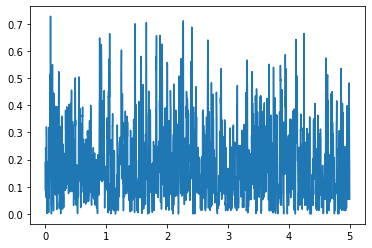

In [16]:
plt.plot([i*5/len(losses) for i in range(len(losses))], losses)

In [17]:
len(losses)/5

511.0

In [18]:
np.mean(losses[-511:])**0.5  # approx rmse

0.4191313467870307

In [19]:
# getting preds
with torch.no_grad():
#     model.eval()
    preds = []
    batch_size = 8
    for i in range(0, len(clean_df), batch_size):
        temp = tokenizer(list(clean_df['clean_comment'][i:i+batch_size]), padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
        preds.append(model(temp['input_ids'].to(device), temp['attention_mask'].to(device)).cpu().detach().numpy().tolist())
len(preds)

256

In [20]:
preds

[[[-0.04186757653951645],
  [-0.04186631739139557],
  [-0.04186646267771721],
  [-0.041866548359394073],
  [-0.04186636209487915],
  [-0.04186646267771721],
  [-0.04186452925205231],
  [-0.04186646267771721]],
 [[-0.0418664924800396],
  [-0.04186708852648735],
  [-0.041864797472953796],
  [-0.04186587780714035],
  [-0.041866712272167206],
  [-0.04186646267771721],
  [-0.04186539351940155],
  [-0.04186646267771721]],
 [[-0.04186646267771721],
  [-0.04186646267771721],
  [-0.04186747595667839],
  [-0.04186582565307617],
  [-0.0418664775788784],
  [-0.04186646267771721],
  [-0.04186646267771721],
  [-0.04186723753809929]],
 [[-0.04186646267771721],
  [-0.04186629131436348],
  [-0.04186353087425232],
  [-0.04186646267771721],
  [-0.041866485029459],
  [-0.04186646267771721],
  [-0.04186646267771721],
  [-0.04186646267771721]],
 [[-0.041867323219776154],
  [-0.041865866631269455],
  [-0.04186646267771721],
  [-0.04186646267771721],
  [-0.04186646267771721],
  [-0.04186616837978363],
  [-0.0

In [21]:
sum(sum(preds, []), [])

[-0.04186757653951645,
 -0.04186631739139557,
 -0.04186646267771721,
 -0.041866548359394073,
 -0.04186636209487915,
 -0.04186646267771721,
 -0.04186452925205231,
 -0.04186646267771721,
 -0.0418664924800396,
 -0.04186708852648735,
 -0.041864797472953796,
 -0.04186587780714035,
 -0.041866712272167206,
 -0.04186646267771721,
 -0.04186539351940155,
 -0.04186646267771721,
 -0.04186646267771721,
 -0.04186646267771721,
 -0.04186747595667839,
 -0.04186582565307617,
 -0.0418664775788784,
 -0.04186646267771721,
 -0.04186646267771721,
 -0.04186723753809929,
 -0.04186646267771721,
 -0.04186629131436348,
 -0.04186353087425232,
 -0.04186646267771721,
 -0.041866485029459,
 -0.04186646267771721,
 -0.04186646267771721,
 -0.04186646267771721,
 -0.041867323219776154,
 -0.041865866631269455,
 -0.04186646267771721,
 -0.04186646267771721,
 -0.04186646267771721,
 -0.04186616837978363,
 -0.041866470128297806,
 -0.04186646267771721,
 -0.041866403073072433,
 -0.041866485029459,
 -0.04186646267771721,
 -0.041866

## Siamese Embeddings

In [19]:
class MuRILemb(nn.Module):

    def __init__(self, dropout=0.2):

        super(MuRILemb, self).__init__()

        self.bert = AutoModelForMaskedLM.from_pretrained('google/muril-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.l1 = nn.Linear(768, 200)
        self.relu = nn.ReLU()
        
        modules = [self.bert.bert.embeddings, *self.bert.bert.encoder.layer[:-3]]  # freeze all but last few
        for module in modules:
            for param in module.parameters():
                param.requires_grad = False

    def forward(self, input_id, mask):

        b = self.bert(input_ids= input_id, attention_mask=mask, output_hidden_states=True)
        x = b.hidden_states[-1][:, 0]  # this is what the bertpooler implementation does
        x = self.dropout(x)
        x = self.l1(x)

        return x


class SiameseModel(nn.Module):
    def __init__(self):
        super(SiameseModel, self).__init__()
        
        self.embedder = MuRILemb()
        self.cos = nn.CosineSimilarity()
    
    def forward(self, inputs1, inputs2):
        # each input is (input_id, mask)
        emb1 = self.embedder(inputs1[0], inputs1[1])
        emb2 = self.embedder(inputs2[0], inputs2[1])
        sim = self.cos(emb1, emb2)
        return sim
    
    def get_emb(self, input_id, mask):
        x = self.embedder(input_id, mask)
        return x

In [12]:
clean_df.head()

,clean_title,clean_comment,url,avg_score,target
0,Shashi Tharoor Set To Run For Congress Preside...,Extremely valid points but I believe he has th...,/r/india/comments/xif8wm/shashi_tharoor_set_to...,-1.0,-0.50
1,Yogi government puts Kolkata's image as part o...,Even if the ad was designed by the newspaper t...,/r/india/comments/pmn9o3/yogi_government_puts_...,-1.0,-0.50
2,"An attempt to address the list of ""simplified""...",Diverse population including Muslims. Welcomin...,/r/india/comments/ebdeup/an_attempt_to_address...,-1.5,-0.75
3,You guys noticing what's happening in Sri Lanka?,What a joke. They didn't create any propaganda...,/r/india/comments/tt1ryh/you_guys_noticing_wha...,0.0,0.00
4,Just got abused on the train by a hyper nation...,Ohoo bahut bura laga ye sunke ki aap Undergarm...,/r/india/comments/rh2kcs/just_got_abused_on_th...,-2.0,-1.00


In [13]:
def sim_score(s1, s2):
    # given 2 scores such that both are [-1, 1] but not 0, we can take 
    # magnitude as geometric mean of absolute scores, sign from multiplying?
    
    # rescaling to 0 to 1 range due to cosine similarity
    temp = s1*s2/(abs(s1)*abs(s2))**0.5
    return (temp+1)/2

In [14]:
sim_score(-1, 0.5), sim_score(1, 0.25)

(0.14644660940672627, 0.75)

In [25]:
df_size = 1000  # size of final dataset wanted
temp = clean_df[clean_df['avg_score']!=0].copy()
temp = temp[['clean_comment', 'target']].sample(df_size*2, replace=True)
d1 = temp[:df_size].copy().to_records()
d2 = temp[df_size:].copy().to_records()

pair_dict = {'c1':[], 'c2':[], 'sim':[]}
for i in range(df_size):
    pair_dict['c1'].append(d1[i].clean_comment)
    pair_dict['c2'].append(d2[i].clean_comment)
    pair_dict['sim'].append(sim_score(d1[i].target, d2[i].target))
pair_df = pd.DataFrame.from_dict(pair_dict)
pair_df

,c1,c2,sim
0,I agree that 4th of july and 31st dec are equa...,What's wrong with staying United against China...,0.750000
1,I think while Shashi has a lot of sensibilitie...,Sikhi and weapons go hand in hand. I also don'...,0.323223
2,These things happen when the miscreants are ba...,"True af. People are sheeps man, shitting what ...",0.625000
3,"This is messed up, and I m not surprised, but ...",I live in haryana near Punjab border.. nd I ca...,0.716506
4,"Dude, I tried that with you, with a well reaso...",These kind of posts could never be seen on tha...,0.806186
...,...,...,...
995,I live in haryana near Punjab border.. nd I ca...,Are we going to pretend that women that age ha...,0.676777
996,Dude the right to peacefully protest against t...,Mujhe to bahut gussa aata h bahut si cheezo ko...,0.146447
997,Nahi bhai pappu aur jyada confuse kar dega... ...,They want to irritate their lives so that they...,0.193814
998,India overwhelmingly supports CAA... We have g...,Never forget the sacrifice of great Tukaram Om...,0.750000


(array([ 14., 132., 170., 179.,   0.,   0., 167., 187., 127.,  24.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

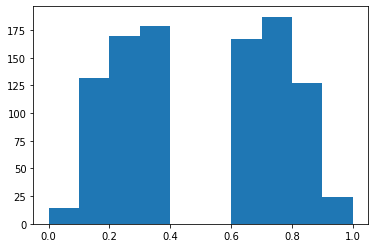

In [26]:
plt.hist(pair_df.sim)

In [63]:
cos = nn.CosineSimilarity()
cos(torch.randn(5, 128), torch.randn(5, 128))

tensor([ 0.0671, -0.0353,  0.0035,  0.0252,  0.0333])

In [17]:
def siamese_train_loop(model, train_df, num_epochs, batch_size, lr=0.001):
    model.train()  # set to train mode just in case
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    
    df = train_df.copy()
    for _ in range(num_epochs):
        df = df.sample(frac=1).reset_index(drop=True)  # shuffle order
        for i in range(int(np.ceil(len(df)/batch_size))):
            model.zero_grad()
            
            # getting inputs
            batch = df[i:i+batch_size]
            targets = torch.tensor(list(batch['sim'])).to(device)
            
            temp = tokenizer(list(batch['c1']), padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
            inputs1 = temp['input_ids'].to(device), temp['attention_mask'].to(device)
            
            temp = tokenizer(list(batch['c2']), padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
            inputs2 = temp['input_ids'].to(device), temp['attention_mask'].to(device)
            
            # training model
            preds = model(inputs1, inputs2)
            batch_loss = criterion(preds, targets)
            batch_loss.backward()
            optimizer.step()
            
            losses.append(batch_loss.item())
            
            # excplicitly delete variables in cuda
            del targets, temp, inputs1, inputs2, preds, batch_loss
    return model, losses

In [20]:
siamese_model = SiameseModel().to(device)

Some weights of the model checkpoint at google/muril-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 3         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1832 MB |    4311 MB |   64423 GB |   64421 GB |
|       from large pool |    1830 MB |    4307 MB |   64403 GB |   64401 GB |
|       from small pool |       2 MB |       5 MB |      20 GB |      20 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1832 MB |    4311 MB |   64423 GB |   64421 GB |
|       from large pool |    1830 MB |    4307 MB |   64403 GB |

In [27]:
%%time
siamese_model, siamese_losses = siamese_train_loop(siamese_model, pair_df, num_epochs=5, batch_size=4, lr=0.0001)

Wall time: 11min 18s


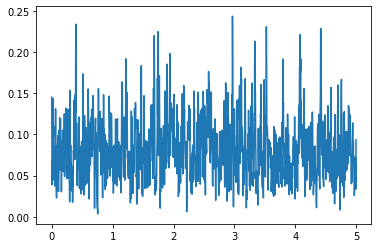

In [28]:
plt.plot([i*5/len(siamese_losses) for i in range(len(siamese_losses))], siamese_losses)

In [29]:
np.mean(siamese_losses)**0.5  # rmse

0.28573366440409925

In [30]:
len(siamese_losses)

1250

In [31]:
1 - np.mean(siamese_losses)/np.mean(pair_df['sim']**2)  # approx r2

0.7469985474633241

In [32]:
torch.save(siamese_model, 'models/siamese_model.pkl')

### Classification from Siamese Embeddings

In [33]:
clean_df.head()

,clean_title,clean_comment,url,avg_score,target
0,Shashi Tharoor Set To Run For Congress Preside...,Extremely valid points but I believe he has th...,/r/india/comments/xif8wm/shashi_tharoor_set_to...,-1.0,-0.50
1,Yogi government puts Kolkata's image as part o...,Even if the ad was designed by the newspaper t...,/r/india/comments/pmn9o3/yogi_government_puts_...,-1.0,-0.50
2,"An attempt to address the list of ""simplified""...",Diverse population including Muslims. Welcomin...,/r/india/comments/ebdeup/an_attempt_to_address...,-1.5,-0.75
3,You guys noticing what's happening in Sri Lanka?,What a joke. They didn't create any propaganda...,/r/india/comments/tt1ryh/you_guys_noticing_wha...,0.0,0.00
4,Just got abused on the train by a hyper nation...,Ohoo bahut bura laga ye sunke ki aap Undergarm...,/r/india/comments/rh2kcs/just_got_abused_on_th...,-2.0,-1.00


In [34]:
with torch.no_grad():
    siamese_model.eval()
    temp = tokenizer(list(clean_df['clean_comment'][:5]), padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
    temp_embs = siamese_model.get_emb(temp['input_ids'].to(device), temp['attention_mask'].to(device)).cpu().detach().numpy()
temp_embs

array([[-1.23233171e-02,  9.16410331e-03, -9.98836197e-03,
        -1.48510616e-02,  1.20317191e-03, -6.32020063e-04,
        -9.51469038e-03,  9.14787501e-03, -7.74967112e-03,
        -1.37430802e-02,  9.17028636e-04, -2.52968073e-03,
         7.07013765e-03,  1.07331462e-02,  2.67621712e-03,
        -1.57944225e-02,  2.25701742e-02, -1.45315379e-03,
        -2.47358400e-02, -9.62265860e-03,  1.90248434e-03,
         4.56789136e-03,  2.52414495e-03,  4.84470837e-03,
         1.08348373e-02,  2.54079700e-04,  1.34881139e-02,
         4.00158614e-02, -1.92111265e-02, -1.44691207e-03,
         8.91999155e-03, -1.75834209e-01,  6.62859855e-03,
        -2.02636719e-02,  2.08885912e-02,  1.42671829e-02,
         1.27223181e-02, -6.01575151e-03,  3.97900119e-04,
        -2.02394053e-02,  1.55674443e-02,  2.16914862e-02,
         1.19702406e-02,  1.00055989e-02, -1.15334447e-02,
         7.63931684e-03,  9.46526602e-03, -2.21038051e-03,
        -1.73629522e-02,  9.03666485e-03, -1.72467530e-0

In [41]:
with torch.no_grad():
    siamese_model.eval()
    comment_embs = []
    batch_size=4
    for i in range(0, len(clean_df), batch_size):
        temp = tokenizer(list(clean_df['clean_comment'][i:i+batch_size]), padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
        comment_embs.extend(siamese_model.get_emb(temp['input_ids'].to(device), temp['attention_mask'].to(device)).cpu().detach().numpy().tolist())
len(comment_embs)

2044

In [110]:
comment_embs[0]

[0.0010330984368920326,
 0.0021282322704792023,
 0.010343076661229134,
 0.008804318495094776,
 0.006543041206896305,
 -0.00418749637901783,
 -0.004169367253780365,
 0.01086103543639183,
 0.00490739569067955,
 -0.01188814640045166,
 0.01522417739033699,
 0.009816281497478485,
 -0.005128994584083557,
 -0.009730320423841476,
 0.001095877494663,
 0.001436181366443634,
 0.011248903349041939,
 0.013945233076810837,
 0.007011214271187782,
 -0.0005766209214925766,
 -0.0046805404126644135,
 0.0017718560993671417,
 0.005152605473995209,
 -0.0022124052047729492,
 -0.0024828817695379257,
 0.022188086062669754,
 -0.0020463773980736732,
 0.0009299931116402149,
 0.00382344052195549,
 -0.006208650767803192,
 0.00835149921476841,
 0.0031979791820049286,
 -0.0016398960724473,
 0.0022911299020051956,
 -0.006500369869172573,
 -0.0002338513731956482,
 0.003184921108186245,
 -0.008606663905084133,
 -0.007743306457996368,
 0.003949424251914024,
 0.004938815254718065,
 -0.0035108327865600586,
 -0.018039464950

In [44]:
np.max(np.array(comment_embs[12])-np.array(comment_embs[42]))

1.401454210281372e-05

In [45]:
emb_dict = {'comment':list(clean_df['clean_comment']), 'target':list(clean_df['target']), 'emb':comment_embs}

In [112]:
with open('siamese_embeddings.json', 'w') as fileobj:
    json.dump(emb_dict, fileobj)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(emb_dict['emb'], emb_dict['target'], test_size = 0.3, random_state = 123)

In [47]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
lasso = linear_model.Lasso(alpha = 5e-2)  # higher alpha means more weights are "dropped"
lasso.fit(X_train, y_train)

Lasso(alpha=0.05)

In [53]:
y_pred = lasso.predict(X_test)

In [54]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.4235634209638861

In [167]:
y_train_pred = lasso.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_train_pred))

0.41869282195222374

In [55]:
for i in range(len(y_test)):
    print(y_test[i], '\t', y_pred[i])

0.0 	 -0.04548822066086966
-0.25 	 -0.0359112027299842
0.0 	 -0.00532681584862299
-0.5 	 -0.028270260054304018
0.0 	 -0.032379178709008874
-0.25 	 -0.04656136130430148
0.0 	 -0.03558803371950367
-0.75 	 -0.029733217690268588
0.0 	 -0.033708707988475674
0.5 	 -0.0320100689719609
0.5 	 -0.02225944588708992
-0.5 	 -0.04005450688541198
0.25 	 -0.03797039727213578
0.25 	 -0.028691739443123636
-0.25 	 -0.04474594205405832
0.0 	 -0.03849435172769572
0.25 	 -0.04673972022162538
0.0 	 -0.034663402131313144
0.0 	 -0.03211737553491658
0.75 	 -0.03706870015794359
1.0 	 -0.03283176007051036
0.0 	 -0.02979045819627723
0.5 	 -0.035084908435629274
-1.0 	 -0.04032253270157407
0.5 	 -0.02235932903986454
0.0 	 -0.03715020558825839
1.0 	 -0.011350482968024479
0.0 	 -0.03294775399287494
0.5 	 -0.030029015282177735
-1.0 	 -0.031140215509237044
0.25 	 0.004092768390478459
0.75 	 -0.03176326733131531
0.5 	 -0.0346188360383773
0.5 	 -0.03796319726414357
-0.25 	 -0.032847854931774015
-0.5 	 -0.03273336954664321

In [51]:
ridge = linear_model.Ridge(alpha=10)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

0.43908993782073796

In [178]:
for i in range(len(y_test)):
    print(y_test[i], '\t', y_pred[i])

-1.0 	 -0.07622657016206058
0.5 	 0.23385754537397396
0.25 	 -0.3259443551562532
0.25 	 0.005254937110673999
0.0 	 0.011024963905050943
0.0 	 -0.1265029689677056
0.0 	 -0.12341728673240017
0.5 	 -0.1578357453837633
0.0 	 0.00899804854313034
0.0 	 -0.10571387424092257
0.0 	 0.3612146668205599
-1.0 	 -0.15262880367201365
-1.0 	 -0.1972827070107659
-0.5 	 -0.15774905263726113
-1.0 	 -0.31316898675076593
0.0 	 -0.1751757723914762
-0.5 	 -0.3131587978442374
0.0 	 -0.21518862387139748
-0.5 	 -0.11115337627521504
-1.0 	 0.046634901561095635
-0.25 	 -0.7104028333788888
0.5 	 0.25449757145979385
0.0 	 -0.21296936579423847
-0.25 	 0.16283473092382056
-0.25 	 -0.1835590942716812
-0.25 	 -0.07600585494342786
0.25 	 0.33163753576609484
0.25 	 0.3136609652706106
-0.5 	 0.35449104382498653
0.25 	 -0.09740304466096371
-0.5 	 -0.055500487369619544
0.0 	 -0.28377856524363204
0.0 	 -0.023954258342202342
0.25 	 -0.914825321050503
1.0 	 0.3387436714857678
-0.5 	 0.30604497764726407


In [52]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

0.45126367384251553

In [212]:
xgb = xg.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.05)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

0.4763697692583421

In [213]:
for i in range(len(y_test)):
    print(y_test[i], '\t', y_pred[i])

-1.0 	 -0.15857185
0.5 	 0.63727
0.25 	 -0.13212693
0.25 	 -0.032253362
0.0 	 0.36850685
0.0 	 -0.15306991
0.0 	 -0.13987792
0.5 	 -0.4351816
0.0 	 -0.1494668
0.0 	 -0.00982944
0.0 	 0.16662015
-1.0 	 -0.26590288
-1.0 	 -0.19639434
-0.5 	 -0.39096442
-1.0 	 -0.16072357
0.0 	 -0.3075524
-0.5 	 -0.059832126
0.0 	 -0.11484269
-0.5 	 -0.4233838
-1.0 	 0.13115318
-0.25 	 -0.4784529
0.5 	 0.39380956
0.0 	 -0.40912884
-0.25 	 0.0021641864
-0.25 	 -0.10086639
-0.25 	 0.05441005
0.25 	 0.5123986
0.25 	 -0.017556492
-0.5 	 0.028030597
0.25 	 -0.1350653
-0.5 	 -0.004816406
0.0 	 -0.13254924
0.0 	 -0.0077196714
0.25 	 -0.17632467
1.0 	 0.390759
-0.5 	 0.41259316


In [57]:
np.std(y_pred)

0.007401694259806469

In [56]:
def convert_to_classifier(targets, preds, threshold=1/3):
    new_targets = [x/abs(x) if x!=0 else 0. for x in targets]
    new_preds = [x/abs(x) if abs(x)>threshold else 0. for x in preds]
    return new_targets, new_preds

In [58]:
new_y_test, new_y_pred = convert_to_classifier(y_test, y_pred, threshold=0.004)

In [59]:
np.mean([int(new_y_test[i]==new_y_pred[i]) for i in range(len(new_y_test))])

0.3485342019543974

## Stupid model

In [10]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

In [11]:
# model_name = 'bert-base-cased'
# model_name = "google/muril-base-cased"
model_name = "meedan/indian-sbert"

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokenizer = BertTokenizer.from_pretrained(model_name)

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1).to(device)
# model = BertForSequenceClassification.from_pretrained(model_name, num_labels=1).to(device)

Some weights of the model checkpoint at meedan/indian-sbert were not used when initializing XLMRobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at meedan/indian-sbert and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to

In [14]:
with torch.no_grad():
    temp = tokenizer(list(clean_df['clean_comment'][:5]), padding='max_length', max_length = 256, truncation=True, return_tensors="pt")
    temp_pred = model(temp['input_ids'].to(device), temp['attention_mask'].to(device))
    print(temp_pred[0].squeeze(1))

tensor([-0.1444, -0.1408, -0.2312, -0.1846,  0.0533], device='cuda:0')


In [15]:
def train_loop(model, train_df, num_epochs, batch_size, lr=0.0001):
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    
    inputs = train_df.copy()
    for _ in range(num_epochs):
        inputs = inputs.sample(frac=1).reset_index(drop=True)  # shuffle order
        for i in range(int(np.ceil(len(inputs)/batch_size))):
            model.zero_grad()
            
            # getting inputs
            batch = list(inputs['clean_comment'][i:i+batch_size])
            targets = torch.tensor(list(inputs['target'][i:i+batch_size])).to(device)
            try:
                temp = tokenizer(batch, padding='max_length', max_length = 256, truncation=True, return_tensors="pt")
            except ValueError:
                print("Error with following batch, skipped:")
                print(len(batch))
                print(batch)
                print()
                continue
            input_ids, attention_mask = temp['input_ids'].to(device), temp['attention_mask'].to(device)
            
            # training model
            preds = model(input_ids, attention_mask)[0].squeeze(1)
            batch_loss = criterion(preds, targets)
            batch_loss.backward()
            optimizer.step()
            
            losses.append(batch_loss.item())
            
            # excplicitly delete variables in cuda
            del batch, targets, temp, input_ids, attention_mask, preds, batch_loss
    return model, losses

In [16]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1060 MB |    1118 MB |    2820 MB |    1760 MB |
|       from large pool |    1060 MB |    1117 MB |    2820 MB |    1759 MB |
|       from small pool |       0 MB |       0 MB |       0 MB |       0 MB |
|---------------------------------------------------------------------------|
| Active memory         |    1060 MB |    1118 MB |    2820 MB |    1760 MB |
|       from large pool |    1060 MB |    1117 MB |    2820 MB |

In [18]:
model

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [17]:
# optional freezing
modules = [model.roberta.embeddings, *model.roberta.encoder.layer[:-3]]  # freeze all but last few
for module in modules:
    for param in module.parameters():
        param.requires_grad = False

In [18]:
%%time
model, losses = train_loop(model, clean_df, num_epochs=5, batch_size=1, lr=0.00001)

Wall time: 4min 20s


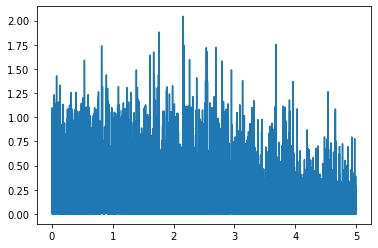

In [19]:
plt.plot([i*5/len(losses) for i in range(len(losses))], losses)

In [20]:
len(losses)/5

2044.0

In [21]:
np.mean(losses[-len(losses)//5:])**0.5  # rmse

0.26768123724785287

In [22]:
1 - np.mean(losses[-128:])/np.mean(clean_df['target']**2)  # approx r2

0.6277961153631195

In [23]:
# getting preds
with torch.no_grad():
    model.eval()
    preds = []
    batch_size = 16
    for i in range(0, len(clean_df), batch_size):
        temp = tokenizer(list(clean_df['clean_comment'][i:i+batch_size]), padding='max_length', max_length = 256, truncation=True, return_tensors="pt")
        preds.append(model(temp['input_ids'].to(device), temp['attention_mask'].to(device))[0].cpu().detach().numpy().tolist())
len(preds)

128

In [24]:
preds

[[[-0.174240842461586],
  [-0.04256206750869751],
  [-0.4228880703449249],
  [0.0021354234777390957],
  [-0.6138954758644104],
  [-0.6015530824661255],
  [-0.1884886920452118],
  [0.22552631795406342],
  [-0.7248070240020752],
  [-0.0640624463558197],
  [0.041456785053014755],
  [0.17302069067955017],
  [0.5381286144256592],
  [-0.8977206945419312],
  [-1.0669480562210083],
  [0.2741997241973877]],
 [[-0.058332305401563644],
  [0.02609911747276783],
  [0.16163145005702972],
  [-0.04104716703295708],
  [0.3677006661891937],
  [0.47900328040122986],
  [0.07294250279664993],
  [0.06926120817661285],
  [-0.029493721202015877],
  [-9.57650991040282e-06],
  [-0.10052871704101562],
  [-0.33281251788139343],
  [-0.28882110118865967],
  [-0.1000802144408226],
  [-0.15046142041683197],
  [-0.07873242348432541]],
 [[0.026745406910777092],
  [-0.033601220697164536],
  [0.051005490124225616],
  [0.0386928953230381],
  [0.2676398456096649],
  [0.2678189277648926],
  [0.05914510414004326],
  [-0.0731

In [25]:
preds = sum(sum(preds, []), [])
preds

[-0.174240842461586,
 -0.04256206750869751,
 -0.4228880703449249,
 0.0021354234777390957,
 -0.6138954758644104,
 -0.6015530824661255,
 -0.1884886920452118,
 0.22552631795406342,
 -0.7248070240020752,
 -0.0640624463558197,
 0.041456785053014755,
 0.17302069067955017,
 0.5381286144256592,
 -0.8977206945419312,
 -1.0669480562210083,
 0.2741997241973877,
 -0.058332305401563644,
 0.02609911747276783,
 0.16163145005702972,
 -0.04104716703295708,
 0.3677006661891937,
 0.47900328040122986,
 0.07294250279664993,
 0.06926120817661285,
 -0.029493721202015877,
 -9.57650991040282e-06,
 -0.10052871704101562,
 -0.33281251788139343,
 -0.28882110118865967,
 -0.1000802144408226,
 -0.15046142041683197,
 -0.07873242348432541,
 0.026745406910777092,
 -0.033601220697164536,
 0.051005490124225616,
 0.0386928953230381,
 0.2676398456096649,
 0.2678189277648926,
 0.05914510414004326,
 -0.07318560034036636,
 0.40959522128105164,
 0.480093389749527,
 -0.014003016985952854,
 -0.08106124401092529,
 -0.1735615879297

(array([  2.,  17.,  89., 224., 402., 747., 358., 147.,  42.,  16.]),
 array([-1.35758626, -1.10416064, -0.85073502, -0.5973094 , -0.34388378,
        -0.09045815,  0.16296747,  0.41639309,  0.66981871,  0.92324433,
         1.17666996]),
 <BarContainer object of 10 artists>)

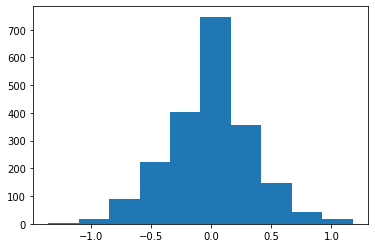

In [26]:
plt.hist(preds)

In [27]:
pred_df = clean_df.copy()
pred_df['preds'] = preds
pred_df.head()

,clean_title,clean_comment,url,avg_score,target,preds
0,Shashi Tharoor Set To Run For Congress Preside...,Extremely valid points but I believe he has th...,/r/india/comments/xif8wm/shashi_tharoor_set_to...,-1.0,-0.50,-0.174241
1,Yogi government puts Kolkata's image as part o...,Even if the ad was designed by the newspaper t...,/r/india/comments/pmn9o3/yogi_government_puts_...,-1.0,-0.50,-0.042562
2,"An attempt to address the list of ""simplified""...",Diverse population including Muslims. Welcomin...,/r/india/comments/ebdeup/an_attempt_to_address...,-1.5,-0.75,-0.422888
3,You guys noticing what's happening in Sri Lanka?,What a joke. They didn't create any propaganda...,/r/india/comments/tt1ryh/you_guys_noticing_wha...,0.0,0.00,0.002135
4,Just got abused on the train by a hyper nation...,Ohoo bahut bura laga ye sunke ki aap Undergarm...,/r/india/comments/rh2kcs/just_got_abused_on_th...,-2.0,-1.00,-0.613895


In [28]:
np.sqrt(mean_squared_error(pred_df['target'], pred_df['preds']))

0.20168810421111308

In [29]:
np.std(pred_df['preds'])

0.3445690768844733

In [30]:
def convert_to_classifier(targets, preds, threshold=1/3):
    new_targets = [x/abs(x) if x!=0 else 0. for x in targets]
    new_preds = [x/abs(x) if abs(x)>threshold else 0. for x in preds]
    return new_targets, new_preds

In [42]:
new_y_test, new_y_pred = convert_to_classifier(pred_df['target'], pred_df['preds'], threshold=0.21)

In [43]:
np.mean([int(new_y_test[i]==new_y_pred[i]) for i in range(len(new_y_test))])

0.7925636007827789

In [41]:
# optimizing threshold
m = 0
threshold = 0.1
for _ in range(30):
    t1, t2 = convert_to_classifier(pred_df['target'], pred_df['preds'], threshold=threshold)
    t3 = np.mean([int(t1[i]==t2[i]) for i in range(len(t1))])
    if t3>m:
        m = t3
        print(threshold)
    threshold += 0.01

0.1
0.11
0.12
0.13
0.14
0.15000000000000002
0.17000000000000004
0.18000000000000005
0.20000000000000007
0.21000000000000008


In [33]:
pred_df[:30]

,clean_title,clean_comment,url,avg_score,target,preds
0,Shashi Tharoor Set To Run For Congress Preside...,Extremely valid points but I believe he has th...,/r/india/comments/xif8wm/shashi_tharoor_set_to...,-1.0,-0.50,-0.174241
1,Yogi government puts Kolkata's image as part o...,Even if the ad was designed by the newspaper t...,/r/india/comments/pmn9o3/yogi_government_puts_...,-1.0,-0.50,-0.042562
2,"An attempt to address the list of ""simplified""...",Diverse population including Muslims. Welcomin...,/r/india/comments/ebdeup/an_attempt_to_address...,-1.5,-0.75,-0.422888
3,You guys noticing what's happening in Sri Lanka?,What a joke. They didn't create any propaganda...,/r/india/comments/tt1ryh/you_guys_noticing_wha...,0.0,0.00,0.002135
4,Just got abused on the train by a hyper nation...,Ohoo bahut bura laga ye sunke ki aap Undergarm...,/r/india/comments/rh2kcs/just_got_abused_on_th...,-2.0,-1.00,-0.613895
5,"Defeat BJP Mission Uttar Pradesh,' Farmers to ...",Not really. As the country has seen for the la...,/r/india/comments/nmyqu4/defeat_bjp_mission_ut...,-2.0,-1.00,-0.601553
6,"Spurned by Congress for years, Dalits in Delhi...",If they focused on campaigning in urban areas ...,/r/india/comments/euipuz/spurned_by_congress_f...,-0.5,-0.25,-0.188489
7,"Government spent nearly 3,723 Crore on ads in ...","This ads are for various awareness programmes,...",/r/IndiaSpeaks/comments/zpnhnr/government_spen...,0.5,0.25,0.225526
8,The standard of prime time debates on our nati...,What else can you expect from Godi Media. All ...,/r/india/comments/118s00j/the_standard_of_prim...,-2.0,-1.00,-0.724807
9,West Bengal government has put total ban on ma...,To fine people for spitting government will ha...,/r/india/comments/dpz5rs/west_bengal_governmen...,0.0,0.00,-0.064062


In [34]:
pred_df.to_csv('indian_sbert_preds.csv', index=False)

In [35]:
torch.save(model, 'models/indian_sbert.pkl')